[![Open In Colab](./images/colab-badge.png)](https://colab.research.google.com/github/abrsvn/pyactr-book/blob/master/notebooks/24_half_normal_prior_for_sigma.ipynb)

The code so far:

In [1]:
# uncomment the lines below to install the correct version of pymc3 and dependencies
# !pip3 install --upgrade 'arviz==0.11.1'
# !pip3 install --upgrade 'pymc3==3.9.3'

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import pandas as pd
import pymc3 as pm

In [3]:
url = 'https://github.com/abrsvn/pyactr-book/blob/master/data/every_each.csv?raw=true'
every_each = pd.read_csv(url)
every_each["quant"] = every_each["quant"].astype('category')
every_each.shape

(347, 2)

In [4]:
every_each["dummy_quant"] = (every_each["quant"]=="each").astype("int")

In [5]:
mean_every = -0.05
mean_difference = 0.1
quant = np.array(every_each["dummy_quant"])

synthetic_RT_means = mean_every + quant * mean_difference
synthetic_RT_means[:15]

array([ 0.05,  0.05, -0.05,  0.05, -0.05, -0.05,  0.05,  0.05, -0.05,
        0.05, -0.05,  0.05,  0.05, -0.05, -0.05])

In [6]:
sigma = 0.25
synthetic_RTs = np.random.normal(synthetic_RT_means, sigma)
synthetic_RTs.round(2)[:25]

array([-0.16,  0.02, -0.47, -0.15,  0.21, -0.39,  0.02, -0.18,  0.1 ,
        0.16, -0.36,  0.2 ,  0.31,  0.04, -0.34, -0.19, -0.54,  0.52,
       -0.01, -0.12, -0.04,  0.18, -0.03,  0.4 ,  0.36])

## Prior for the noise $\sigma$

Now that we understand that the likelihood function has to incorporate some noise, which will need to be estimated from the data, we need to set up a prior for this noise.

Reasoning again from our prior knowledge about residualized log RTs, we know that this noise / variability in data cannot really be larger than maybe about $3$. This can be justified as follows.

- we know that residualized log RTs are between about $-3$ and $3$
- now, if we think of them as being generated from a normal distribution centered somewhere in the interval $[-3, 3]$, a standard deviation (i.e., a noise setting) of about $3$ for this normal distribution covers the interval $[-3, 3]$ easily enough
- this is because a normal distribution spreads probability mass, i.e., predicts likely values to be, within +/- 3 standard deviations from its mean

Therefore, a very weak and non-committal prior for residualized log RT noise would be a half-normal distribution, which is a normal (Gaussian) distribution centered at 0 and 'folded over' so that all the probability mass over negative values gets transferred to the corresponding positive values.

- half-normal distributions correctly require noise / dispersion to be positive
- if we set the standard deviation of this half-normal prior for noise to $10$, we place practically no constraints on the actual value of the noise before we see the data
    - as far as we _a priori_ expect, the noise can be anywhere between $0$ and about $30$, a very diffuse interval that allows for much larger values than $3$
    - however, since this prior assigns higher probabilities to lower values than to larger values, as we can see in the plot below, we do expect that the noise should be smaller rather than larger
    - this makes sense: even though values larger than $3$ are possible as residualized log RT noise, such values are unlikely and they are more and more unlikely as we increase them

To plot a half-normal prior, we can simulate draws from it in the same way we did for the normal priors for the mean RT for _every_ and the mean difference in RT between _each_ and _every_. We do this below, and plot the results.

In [7]:
every_each_model = pm.Model()

with every_each_model:
    half_normal_density = pm.HalfNormal('half_normal_density', sd=10)

with every_each_model:
    trace = pm.sample(draws=5000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [half_normal_density]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


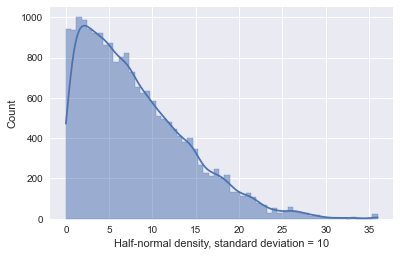

In [8]:
fig, ax = plt.subplots(ncols=1, nrows=1)
fig.set_size_inches(5.5, 3.5)
sns.histplot(trace['half_normal_density'], kde=True,
             element='step', ax=ax)
ax.set_xlabel('Half-normal density, standard deviation = 10')
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)